# GSOM Jupyter platform optimizing project
## Read files (logs) from S3 with Spark

### 1. Libraries

In [1]:
import os
import sys
import json
import boto3
import logging
import psycopg2
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, struct, countDistinct
import multiprocessing
pd.set_option('display.max_columns', None)
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
print('max cores available:', N_CORES)

max cores available: 5


In [2]:
import os
if not os.path.exists("images"):
    os.mkdir("images")

### 2. Credentials and Spark settings

In [3]:
BUCKET = 'rawdata-test-logs-jhub'
with open('access_jhub.json') as file:
    access_data = json.load(file)

In [4]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()
conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '8G')
conf.set('spark.driver.maxResultSize', '4G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st102710/


23/06/01 10:01:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_data['aws_access_key_id'])
spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', access_data['aws_secret_access_key'])
spark._jsc.hadoopConfiguration().set('fs.s3a.impl','org.apache.hadoop.fs.s3a.S3AFileSystem')
spark._jsc.hadoopConfiguration().set('fs.s3a.multipart.size', '104857600')
spark._jsc.hadoopConfiguration().set('fs.s3a.block.size', '33554432')
spark._jsc.hadoopConfiguration().set('fs.s3a.threads.max', '256')
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 'http://storage.yandexcloud.net')
spark._jsc.hadoopConfiguration().set('fs.s3a.aws.credentials.provider', 
                                     'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')

### 3. Structure of the data

#### 3.1. JupyterHub logs

Logs from JupyterHub application can help us to monitor many users' activities.

In [6]:
mask_files = '{}/{fluent-bit-logs/kube.var.log.containers.hub*'

In [7]:
mask_files = '{}/{}/{}/{}/{}/*/*'.format(
    'fluent-bit-logs/kube.var.log.containers.hub*',
    '2022',    # year
    '11',      # month
    '*',      # day
    '*'        # hour
)
# use mask below to load all logs for all the time periods
#mask_files = '{}/{fluent-bit-logs/kube.var.log.containers.hub*'

In [8]:
sdf = spark.read.json(f's3a://{BUCKET}/{mask_files}')

23/06/01 10:02:00 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [9]:
sdf.count()

102374

In [10]:
sdf.printSchema()

root
 |-- date: string (nullable = true)
 |-- kubernetes: struct (nullable = true)
 |    |-- annotations: struct (nullable = true)
 |    |    |-- checksum/config-map: string (nullable = true)
 |    |    |-- checksum/secret: string (nullable = true)
 |    |-- container_hash: string (nullable = true)
 |    |-- container_image: string (nullable = true)
 |    |-- container_name: string (nullable = true)
 |    |-- docker_id: string (nullable = true)
 |    |-- host: string (nullable = true)
 |    |-- labels: struct (nullable = true)
 |    |    |-- app: string (nullable = true)
 |    |    |-- component: string (nullable = true)
 |    |    |-- hub.jupyter.org/network-access-proxy-api: string (nullable = true)
 |    |    |-- hub.jupyter.org/network-access-proxy-http: string (nullable = true)
 |    |    |-- hub.jupyter.org/network-access-singleuser: string (nullable = true)
 |    |    |-- pod-template-hash: string (nullable = true)
 |    |    |-- release: string (nullable = true)
 |    |-- names

In [11]:
sdf.limit(5).toPandas()

,date,kubernetes,log,stream,time
0,2022-11-09T06:05:16.811405Z,((ce8928e0f18c6133a264af378e22ef5e6ca57203ac90...,[I 2022-11-09 06:05:16.810 JupyterHub log:181]...,stderr,2022-11-09T06:05:16.811405358Z
1,2022-11-09T06:05:18.182046Z,((ce8928e0f18c6133a264af378e22ef5e6ca57203ac90...,[I 2022-11-09 06:05:18.181 JupyterHub log:181]...,stderr,2022-11-09T06:05:18.182046579Z
2,2022-11-09T06:05:35.070013Z,((ce8928e0f18c6133a264af378e22ef5e6ca57203ac90...,[I 2022-11-09 06:05:35.069 JupyterHub log:181]...,stderr,2022-11-09T06:05:35.070013458Z
3,2022-11-09T06:05:40.877699Z,((ce8928e0f18c6133a264af378e22ef5e6ca57203ac90...,[I 2022-11-09 06:05:40.877 JupyterHub proxy:31...,stderr,2022-11-09T06:05:40.877699148Z
4,2022-11-09T06:05:46.822653Z,((ce8928e0f18c6133a264af378e22ef5e6ca57203ac90...,[E 2022-11-09 06:05:46.822 JupyterHub gen:623]...,stderr,2022-11-09T06:05:46.822653464Z


We need to clean data in logs and create table for further analysis:

In [12]:
def flat_df(df, prefix=None):
    flat_cols = [c[0] for c in df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in df.dtypes if c[1][:6] == 'struct']
    flat_df = df.select(
        flat_cols + 
        [F.col(ncol + '.' + col).alias(prefix + col if prefix else ncol + '_' + col ) 
         for ncol in nested_cols 
         for col in df.select(ncol + '.*').columns]
    )
    return flat_df

def sqbrackets(sin):
    try:
        s = sin.split('[', 1)[1].split(']')[0]
        msg = sin[len(s) + 2 :].strip()
        s = s.split()
        head = s[0]
        ts = ' '.join(s[1:3])
        svc = s[3]
        typ = s[4].split(':')[0]
        code = s[4].split(':')[1]
    except:
        head, ts, svc, typ, code = '', '', '', '', ''
        msg = sin
    return head, ts, svc, typ, code, msg

In [13]:
sdf = flat_df(sdf, prefix='kuber_')

print(sdf.head())

Row(date='2022-11-09T06:05:16.811405Z', log='[I 2022-11-09 06:05:16.810 JupyterHub log:181] 200 POST /hub/api/users/st068420/activity (st068420@10.112.128.61) 20.96ms\n', stream='stderr', time='2022-11-09T06:05:16.811405358Z', kuber_annotations=Row(checksum/config-map='ce8928e0f18c6133a264af378e22ef5e6ca57203ac904e305aef32d64bc55668', checksum/secret='198e7ec305ee91878887c51de1e183beb52af2563a535e2000d8bf1eacece56b'), kuber_container_hash='jupyterhub/k8s-hub@sha256:b6b4a1a34bf00524533de536eb34c92f9f873e0455ec38526a4cd3d55cccb64e', kuber_container_image='jupyterhub/k8s-hub:0.11.1', kuber_container_name='hub', kuber_docker_id='923d90cac2e706544cb7e05545ac784ad009b5bc4a0aa1614a8b4dfa06b31959', kuber_host='cl1flrrk4hvdbm084md4-ahoc', kuber_labels=Row(app='jupyterhub', component='hub', hub.jupyter.org/network-access-proxy-api='true', hub.jupyter.org/network-access-proxy-http='true', hub.jupyter.org/network-access-singleuser='true', pod-template-hash='5bb9b9c56c', release='jhub'), kuber_name

In [14]:
sdf = sdf.withColumn("checksum_config_map", sdf.kuber_annotations["checksum/config-map"]) \
         .withColumn("checksum_secret", sdf.kuber_annotations["checksum/secret"]) \
         .withColumn("app", sdf.kuber_labels["app"]) \
         .withColumn("component", sdf.kuber_labels["component"]) \
         .withColumn("network_access_proxy_api", sdf.kuber_labels["hub.jupyter.org/network-access-proxy-api"]) \
         .withColumn("network_access_proxy_http", sdf.kuber_labels["hub.jupyter.org/network-access-proxy-http"]) \
         .withColumn("network_access_singleuser", sdf.kuber_labels["hub.jupyter.org/network-access-singleuser"]) \
         .withColumn("pod_template_hash", sdf.kuber_labels["pod-template-hash"]) \
         .withColumn("release", sdf.kuber_labels["release"]) \
         .drop("kuber_annotations", "kuber_labels")

# Save the flattened PySpark DataFrame 'sdf' to a CSV file
sdf.write.csv("/home/jovyan/my_data.csv", mode="overwrite", header=True, sep=",")

In [15]:
sdf = sdf.drop('kuber_annotations', 'kuber_labels')

In [16]:
# List files in the directory
file_list = os.listdir('/home/jovyan')

# Print the file list to check if 'my_data.csv' is present
print(file_list)

['Innopolis 21', 'my_data.csv', 'Labwork2.ipynb', 'Untitled Folder', 'Lab1.ipynb', 'HW1.py', 'Labwork_1_EDA_real_estate_data.ipynb', 'Lecture2.ipynb', '.local', 'Final E2E project', 'catboost_info', 'Thesis', 'test.csv', 'results', 'train.csv', 'HW2.ipynb', 'Homework.ipynb', 'logs_new', 'requirements.txt', 'MakePycharmWork', '.bash_history', 'news_story', '.wget-hsts', '__MANUAL', '.jupyter', '__SHARED', 'logs', '.config', 'all_dates_py.txt', 'logs_clean_new.xlsx', 'lost+found', 'all_news.txt', '.ipynb_checkpoints', '__DATA', 'Ex Lecture 2.ipynb', 'NLP Homework - Lisitcyna.ipynb', '__PLATFORM', 'logs1', 'text.txt', 'nltk_data', 'DeepLearning2.ipynb', 'all_dates.txt', 'airflow', 'spb.real.estate.archive.sample5000.tsv', 'malyutin_temp', 'E2E1', 'notebook1a2f587ad3.ipynb', 'cars.csv', 'current_date.txt', 'lab1.2', '__AMEX', 'E2E HW3', 'Kaggle 2', 'dask-worker-space', 'Big Data HW1', 'Project Big Data', 'Master Thesis', 'logs_clean_new.csv', 'logs.csv', 'Big%20Data%20HW1', '.keras', 'curr

In [17]:
udf_sqbrackets = udf(sqbrackets, ArrayType(StringType()))
sdf = sdf.withColumn('log_msg', udf_sqbrackets('log'))
sdf = sdf.select(
    F.col('time').alias('time_stamp'),
    'kuber_container_name',
    'kuber_host',
    'kuber_pod_name',
    F.col('log_msg')[0].alias('log_head'),
    F.col('log_msg')[1].alias('log_timestamp'),
    F.col('log_msg')[2].alias('log_service'),
    F.col('log_msg')[3].alias('log_type'),
    F.col('log_msg')[4].alias('log_code'),
    F.col('log_msg')[5].alias('log_msg')
)
sdf = sdf.withColumn(
    'time_stamp',
    F.to_timestamp("time_stamp", "yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS'Z'")
)
sdf = sdf.withColumn(
    'log_timestamp',
    F.to_timestamp("log_timestamp", "yyyy-MM-dd HH:mm:ss.SSS")
)

In [18]:
sdf.limit(5).toPandas()

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,time_stamp,kuber_container_name,kuber_host,kuber_pod_name,log_head,log_timestamp,log_service,log_type,log_code,log_msg
0,2022-11-09 06:05:16.811405,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:16.810,JupyterHub,log,181,200 POST /hub/api/users/st068420/activity (st0...
1,2022-11-09 06:05:18.182046,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:18.181,JupyterHub,log,181,200 GET /hub/api/authorizations/token/[secret]...
2,2022-11-09 06:05:35.070013,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:35.069,JupyterHub,log,181,200 POST /hub/api/users/st110528/activity (st1...
3,2022-11-09 06:05:40.877699,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:40.877,JupyterHub,proxy,319,Checking routes
4,2022-11-09 06:05:46.822653,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,E,2022-11-09 06:05:46.822,JupyterHub,gen,623,Exception in Future <Task finished name='Task-...


In [19]:
output_path = "/home/jovyan/logs.csv"
sdf.write.csv(output_path, mode="overwrite", header=True, sep=",")

In [20]:
sdf.coalesce(1).write.option("timestampFormat", "yyyy-MM-dd HH:mm:ss.SS").csv('/home/jovyan/logs_new') 

##### 3.1.1. Users' activities

In [21]:
df = sdf.toPandas()
df.shape

(102374, 10)

In [22]:
log_codes = df.log_code.unique()
log_codes

array(['181', '319', '623', '', '43', '104', '757', '402', '1875', '1887',
       '1840', '1344', '380', '173', '567', '681', '1997', '689', '1961',
       '201', '971', '279', '281', '904', '257', '664', '978', '167',
       '1110', '1143', '249', '2349', '2379', '1420', '1725', '2077',
       '2432', '2628', '2664', '2666', '2679', '339', '121', '2739',
       '738', '2069', '2416', '85', '1787', '70', '814', '399', '343',
       '61', '390', '148', '1067', '1415', '1437', '206', '2827', '2463',
       '2475', '2483', '2500', '326', '2170'], dtype=object)

In [23]:
#what are we trying to do here, did we not drop log_msg?
for lc in log_codes:
    print('code', lc)
    print(df[df.log_code == lc].log_msg.values[0])
    try:
        print(df[df.log_code == lc].log_msg.values[1])
    except:
        print('only one record')
    print('-' * 50)

code 181
200 POST /hub/api/users/st068420/activity (st068420@10.112.128.61) 20.96ms
200 GET /hub/api/authorizations/token/[secret] (st054552@10.112.128.62) 22.99ms
--------------------------------------------------
code 319
Checking routes
Checking routes
--------------------------------------------------
code 623
Exception in Future <Task finished name='Task-1324823' coro=<BaseHandler.spawn_single_user.<locals>.finish_user_spawn() done, defined at /usr/local/lib/python3.8/dist-packages/jupyterhub/handlers/base.py:895> exception=TimeoutError('pod/jupyter-st110923 did not start in 300 seconds!')> after timeout
Exception in Future <Task finished name='Task-1325127' coro=<KubeSpawner._start() done, defined at /usr/local/lib/python3.8/dist-packages/kubespawner/spawner.py:1906> exception=TimeoutError('pod/jupyter-st070392 did not start in 300 seconds!')> after timeout
--------------------------------------------------
code 
    Traceback (most recent call last):

      File "/usr/local/lib/

st110132 does not appear to be running at http://hub-5bb9b9c56c-s958d:42735/user/st110132/, shutting it down.
--------------------------------------------------
code 2416
Initialized 16 spawners in 49.812 seconds
Initialized 1 spawners in 0.250 seconds
--------------------------------------------------
code 85
Spawning sever for st072054 with advanced configuration option
Spawning sever for vgarshin with advanced configuration option
--------------------------------------------------
code 1787
400 POST /hub/spawn/st051829?next=%2Fhub%2Fuser%2Fst051829%2Fnotebooks%2FSpaceX_Machine%2520Learning%2520Prediction_Part_5.ipynb (10.112.128.1): st051829 is pending spawn
400 DELETE /hub/api/users/st068420/server (10.112.128.1): st068420 is pending spawn, please wait
--------------------------------------------------
code 70
jupyterhub version 1.3.0 != jupyterhub-singleuser version 3.0.0. This could cause failure to authenticate and result in redirect loops!
jupyterhub version 1.3.0 != jupyterhub

In [24]:
def parce_users_activities(row):
    """
    Ugly function.
    
    You may use dictionary to make it
    more pythonic or something else.
    
    """
    code = row['log_code']
    msg = row['log_msg']
    if code == '43':
        user = msg.split()[-1]
        log = 'logged out'
    elif code == '757':
        user = msg.split()[-1]
        log = 'logged in'
    elif code == '402':
        user = msg.split()[0]
        log = 'pending spawn'
    elif code == '1875':
        user = msg.split()[4].replace('claim-', '').replace(',', '')
        log = 'attempt to create pvc with timeout'
    elif code == '1887':
        user = msg.split()[1].replace('claim-', '')
        log = 'pvc already exists'
    elif code == '1840':
        user = msg.split()[4].replace('jupyter-', '').replace(',', '')
        log = 'attempting to create pod with timeout'
    elif code == '1344':
        user = msg.split('/')[3]
        log = 'failing suspected api request to not-running server'
    elif code == '380':
        user = msg.split()[3]
        log = 'previous spawn failed'
    elif code == '567':
        user = msg.split('/')[4]
        log = 'stream closed while handling '
    elif code == '681':
        user = msg.split()[0].replace('\'s', '')
        log = 'server failed to start'
    elif code == '1997':
        user = msg.split('-')[-1]
        log = 'deleting pod'
    elif code == '689':
        user = msg.split()[3].replace('\'s', '')
        log = 'unhandled error starting with timeout'
    elif code == '1961' or code == '2044':
        user = msg.split()[1].replace('jupyter-', '')
        log = 'restarting pod reflector'
    elif code == '257':
        user = msg.split()[2]
        log = 'adding user to proxy'
    elif code == '664':
        user = msg.split()[1]
        log = 'server is ready'
    elif code == '61' or code == '85':
        user = msg.split()[3]
        log = 'spawning server with advanced configuration option'
    elif code == '1143':
        user = msg.split()[1].replace(':', '')
        log = 'server is slow to stop'
    elif code == '2077':
        user = msg.split()[0]
        log = 'still running'
    elif code == '167':
        user = msg.split()[1]
        log = 'server is already active'
    elif code == '1067' or code == '2022':
        user = msg.split()[1]
        log = 'user server stopped with exit code 1'
    elif code == '1857':
        user = msg.split()[3].replace('jupyter-', '').replace(',', '')
        log = 'found existing pod and attempting to kill'
    elif code == '1861':
        user = msg.split()[2].replace('jupyter-', '').replace(',', '')
        log = 'killed pod and will try starting singleuser pod again'
    elif code == '738':
        user = msg.split()[0].replace(',', '').replace('\'s', '')
        log = 'server never showed up and giving up'
    elif code == '2069':
        user = msg.split()[0].replace(',', '')
        log = 'user does not appear to be running and shutting it down'  
    elif code == '148':
        user = msg.split()[-1]
        log = 'user is running'
    elif code == '1415':
        user = msg.split()[-1]
        log = 'admin requesting spawn on behalf'
    elif code == '1437':
        user = msg.split()[5].replace(',', '')
        log = 'user requested server which user do not own'
    elif code == '626':
        user = msg.split()[1]
        log = 'server is already started'
    elif code == '2085':
        user = msg.split()[0]
        log = 'server appears to have stopped while the hub was down'
    else:
        user, log = '', ''
    return user, log

In [25]:
#heres how I wrote it, please check it

def parse_user_activity(row):
    """
    Parses user activity log message and extracts user and log information.
    
    Returns user and log information as tuple (user, log).
    """
    log_code_mapping = {
        '43': ('logged out', lambda x: x.split()[-1]),
        '757': ('logged in', lambda x: x.split()[-1]),
        '402': ('pending spawn', lambda x: x.split()[0]),
        '1875': ('attempt to create pvc with timeout', lambda x: x.split()[4].replace('claim-', '').replace(',', '')),
        '1887': ('pvc already exists', lambda x: x.split()[1].replace('claim-', '')),
        '1840': ('attempting to create pod with timeout', lambda x: x.split()[4].replace('jupyter-', '').replace(',', '')),
        '1344': ('failing suspected api request to not-running server', lambda x: x.split('/')[3]),
        '380': ('previous spawn failed', lambda x: x.split()[3]),
        '567': ('stream closed while handling', lambda x: x.split('/')[4]),
        '681': ('server failed to start', lambda x: x.split()[0].replace('\'s', '')),
        '1997': ('deleting pod', lambda x: x.split('-')[-1]),
        '689': ('unhandled error starting with timeout', lambda x: x.split()[3].replace('\'s', '')),
        '1961': ('restarting pod reflector', lambda x: x.split()[1].replace('jupyter-', '')),
        '2044': ('restarting pod reflector', lambda x: x.split()[1].replace('jupyter-', '')),
        '257': ('adding user to proxy', lambda x: x.split()[2]),
        '664': ('server is ready', lambda x: x.split()[1]),
        '61': ('spawning server with advanced configuration option', lambda x: x.split()[3]),
        '85': ('spawning server with advanced configuration option', lambda x: x.split()[3]),
        '1143': ('server is slow to stop', lambda x: x.split()[1].replace(':', '')),
        '2077': ('still running', lambda x: x.split()[0]),
        '167': ('server is already active', lambda x: x.split()[1]),
        '1067': ('user server stopped with exit code 1', lambda x: x.split()[1]),
        '2022': ('user server stopped with exit code 1', lambda x: x.split()[1]),
        '1857': ('found existing pod and attempting to kill', lambda x: x.split()[3].replace('jupyter-', '').replace(',', '')),
        '1861': ('killed pod and will try starting singleuser pod again', lambda x: x.split()[2].replace('jupyter-', '').replace(',', '')),
        '738': ('server never showed up and giving up', lambda x: x.split()[0].replace(',', '').replace('\'s', '')),
        '2069': ('user does not appear to be running and shutting it down', lambda x: x.split()[0].replace(',', '')),
        '148': ('user is running', lambda x: x.split()[-1]),
        '1415': ('admin requesting spawn on behalf', lambda x: x.split()[-1]),
        '1437': ('user requested server which user do not own', lambda x: x.split()[5])}

In [26]:
df['user'], df['log'] = zip(*df.apply(parce_users_activities, axis=1))
df.head()

,time_stamp,kuber_container_name,kuber_host,kuber_pod_name,log_head,log_timestamp,log_service,log_type,log_code,log_msg,user,log
0,2022-11-09 06:05:16.811405,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:16.810,JupyterHub,log,181,200 POST /hub/api/users/st068420/activity (st0...,,
1,2022-11-09 06:05:18.182046,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:18.181,JupyterHub,log,181,200 GET /hub/api/authorizations/token/[secret]...,,
2,2022-11-09 06:05:35.070013,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:35.069,JupyterHub,log,181,200 POST /hub/api/users/st110528/activity (st1...,,
3,2022-11-09 06:05:40.877699,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,I,2022-11-09 06:05:40.877,JupyterHub,proxy,319,Checking routes,,
4,2022-11-09 06:05:46.822653,hub,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,E,2022-11-09 06:05:46.822,JupyterHub,gen,623,Exception in Future <Task finished name='Task-...,,


In [27]:
df = df.loc[df.user != '', [
    'log_timestamp',
    'kuber_host',
    'kuber_pod_name',
    'log_type',
    'log_code',
    'log',
    'user'
]].reset_index(drop=True)
df.head()

,log_timestamp,kuber_host,kuber_pod_name,log_type,log_code,log,user
0,2022-11-09 06:06:00.909,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,login,43,logged out,st070392
1,2022-11-09 06:06:02.946,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,base,757,logged in,st070392
2,2022-11-09 06:06:03.033,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,pages,402,pending spawn,st070392
3,2022-11-09 06:06:06.002,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,spawner,1875,attempt to create pvc with timeout,st067810
4,2022-11-09 06:06:06.015,cl1flrrk4hvdbm084md4-ahoc,hub-5bb9b9c56c-s958d,spawner,1887,pvc already exists,st067810


<AxesSubplot:ylabel='user'>

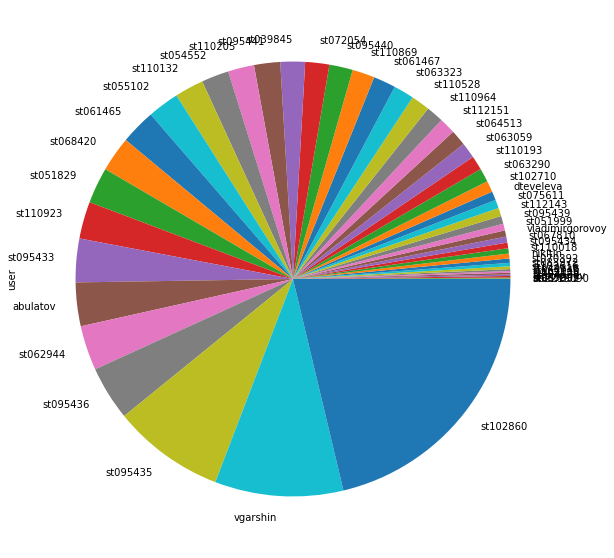

In [28]:
df.groupby(by='user').user.count().sort_values().plot.pie(y='user', figsize=(10, 10))

<AxesSubplot:xlabel='user'>

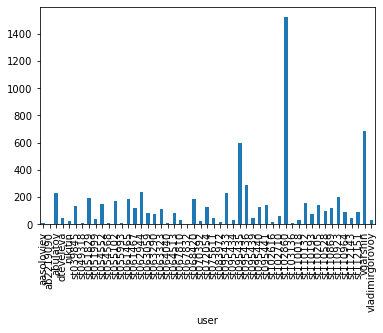

In [29]:
df.groupby(by='user').user.count().plot.bar(y='user')

<AxesSubplot:ylabel='log'>

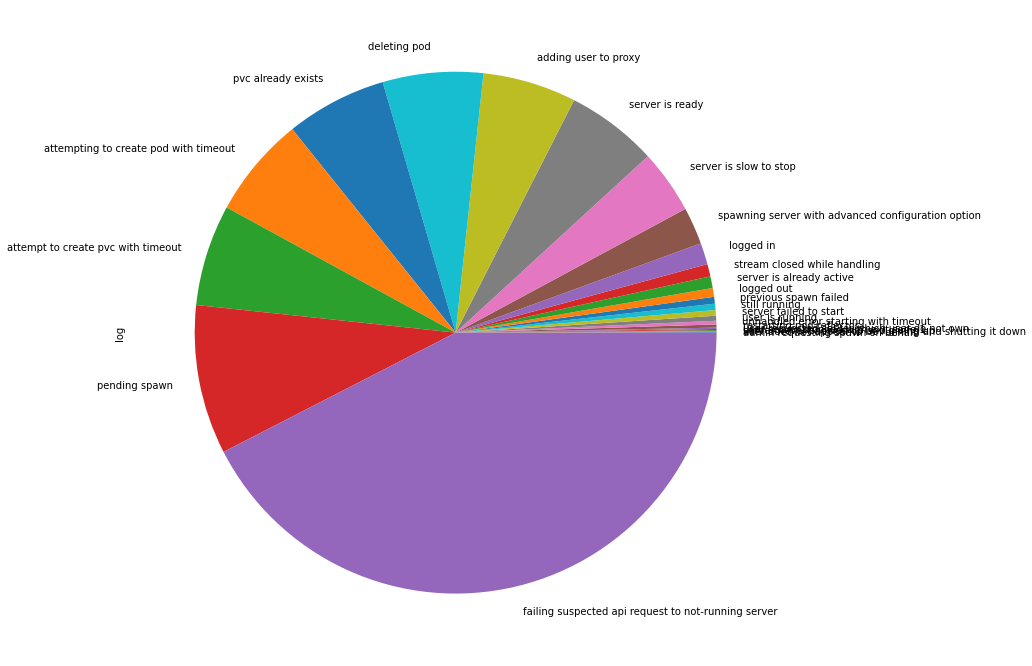

In [30]:
df.groupby(by='log').log.count().sort_values().plot.pie(y='log', figsize=(12, 12))

<AxesSubplot:xlabel='log'>

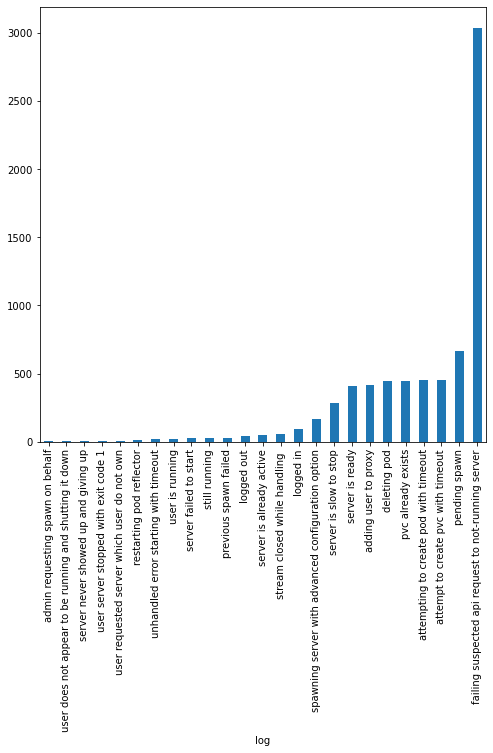

In [31]:
df.groupby(by='log').log.count().sort_values().plot.bar(y='log', figsize=(8, 8))

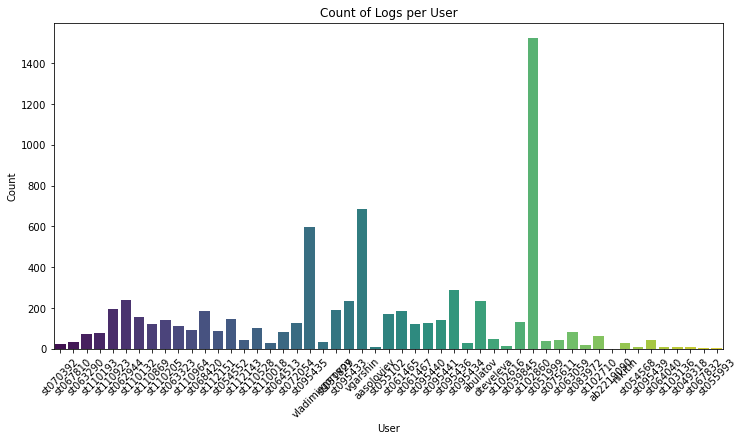

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='user', palette='viridis')
plt.title('Count of Logs per User')
plt.xlabel('User')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

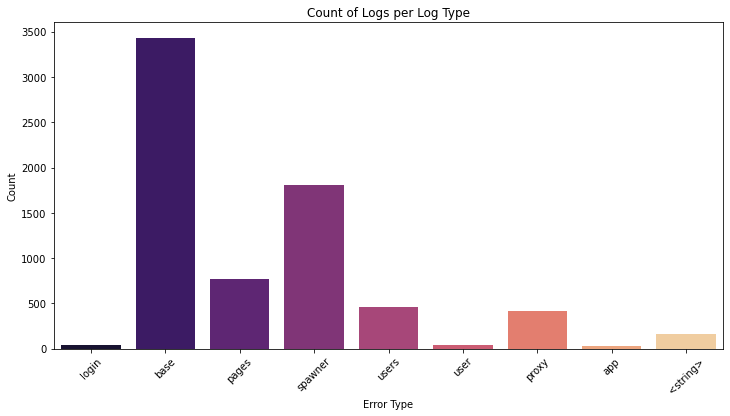

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='log_type', palette='magma')
plt.title('Count of Logs per Log Type')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

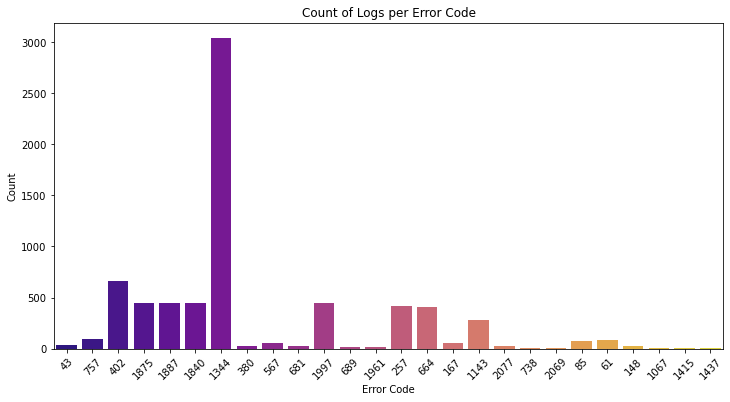

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='log_code', palette='plasma')
plt.title('Count of Logs per Error Code')
plt.xlabel('Error Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

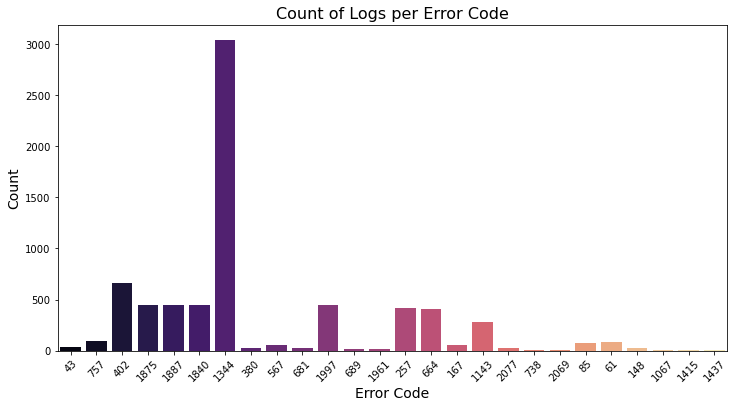

In [35]:
log_codes = sorted(df['log_code'].unique())

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='log_code', palette='magma')
plt.title('Count of Logs per Error Code', fontsize=16)
plt.xlabel('Error Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.savefig('graph.png', dpi=300, bbox_inches='tight')

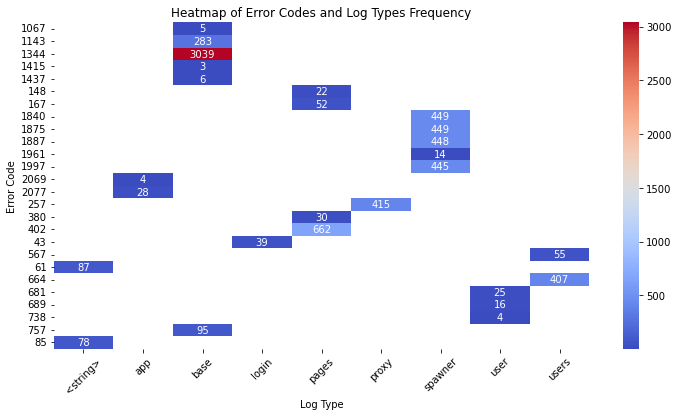

In [36]:
#Heatmap of Error Codes and Log Types Frequency
log_code_log_type = df.pivot_table(index='log_code', columns='log_type', values='log_timestamp', aggfunc='count')
plt.figure(figsize=(12, 6))
sns.heatmap(log_code_log_type, cmap='coolwarm', annot=True, fmt=".0f")
plt.title('Heatmap of Error Codes and Log Types Frequency')
plt.xlabel('Log Type')
plt.ylabel('Error Code')
plt.xticks(rotation=45)
plt.show()

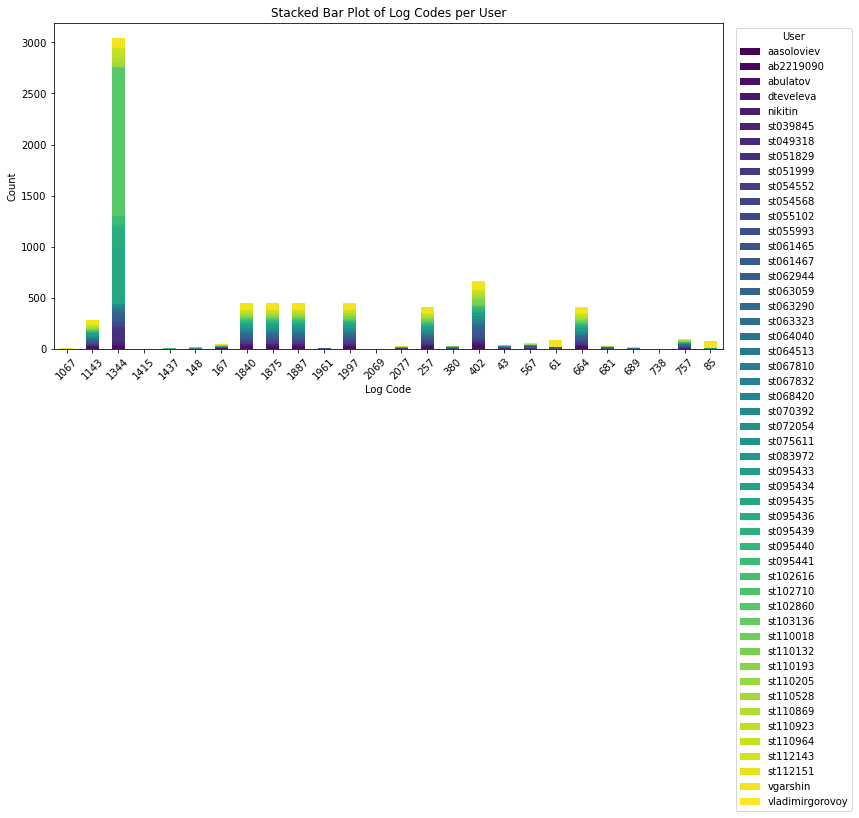

In [37]:
#Stacked Bar Plot of Log Codes per User
log_code_user = df.pivot_table(index='log_code', columns='user', values='log_timestamp', aggfunc='count').fillna(0)
log_code_user.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Stacked Bar Plot of Log Codes per User')
plt.xlabel('Log Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='User', loc='upper right', bbox_to_anchor=(1.20, 1))
plt.show()

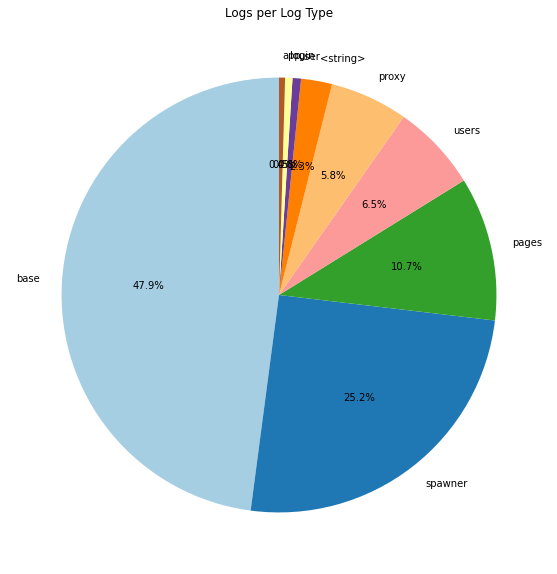

In [38]:
log_type_counts = df['log_type'].value_counts()
plt.figure(figsize=(10, 10))
log_type_counts.plot.pie(autopct='%.1f%%', startangle=90, cmap='Paired')
plt.title('Logs per Log Type')
plt.ylabel('')
plt.show()

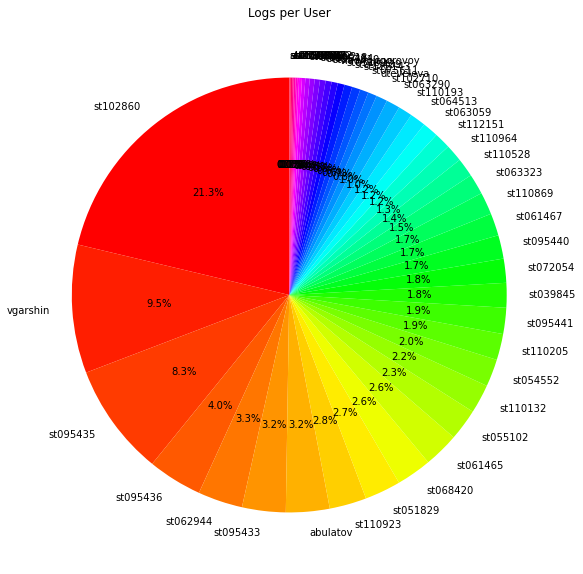

In [39]:
user_counts = df['user'].value_counts()
plt.figure(figsize=(10, 10))
user_counts.plot.pie(autopct='%.1f%%', startangle=90, cmap='hsv')
plt.title('Logs per User')
plt.ylabel('')
plt.savefig('graph2.png', dpi=300, bbox_inches='tight')

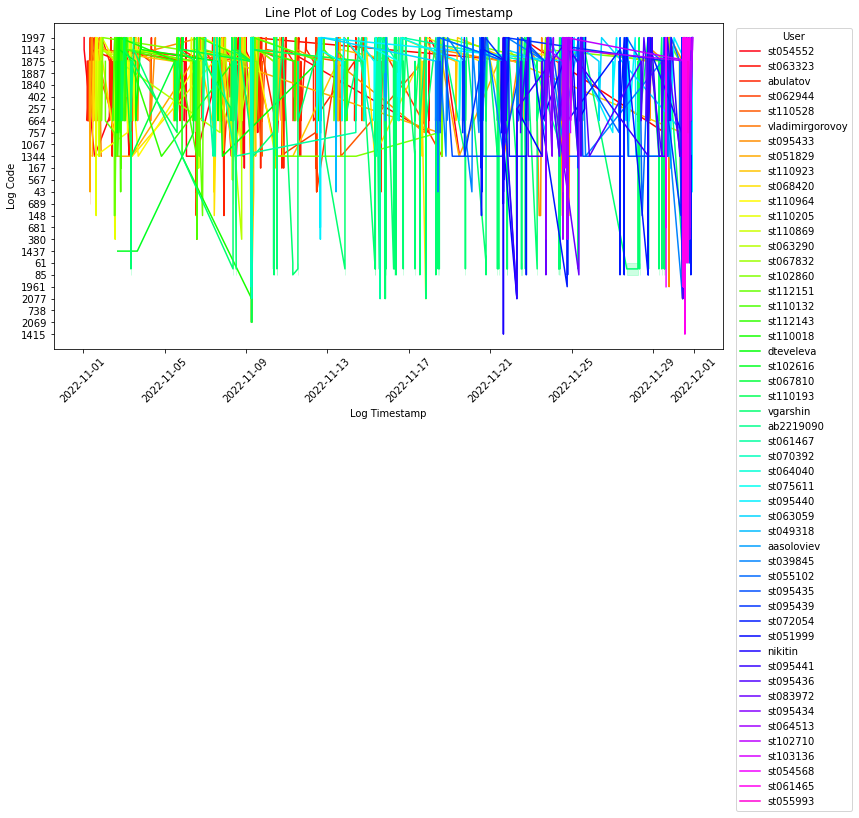

In [40]:
#Line plot of log codes by log timestamp
df['log_timestamp'] = pd.to_datetime(df['log_timestamp'])
df_sorted = df.sort_values(by='log_timestamp')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x='log_timestamp', y='log_code', hue='user', palette='gist_rainbow')
plt.title('Line Plot of Log Codes by Log Timestamp')
plt.xlabel('Log Timestamp')
plt.ylabel('Log Code')
plt.xticks(rotation=45)
plt.legend(title='User', loc='upper right', bbox_to_anchor=(1.20, 1))
plt.show()

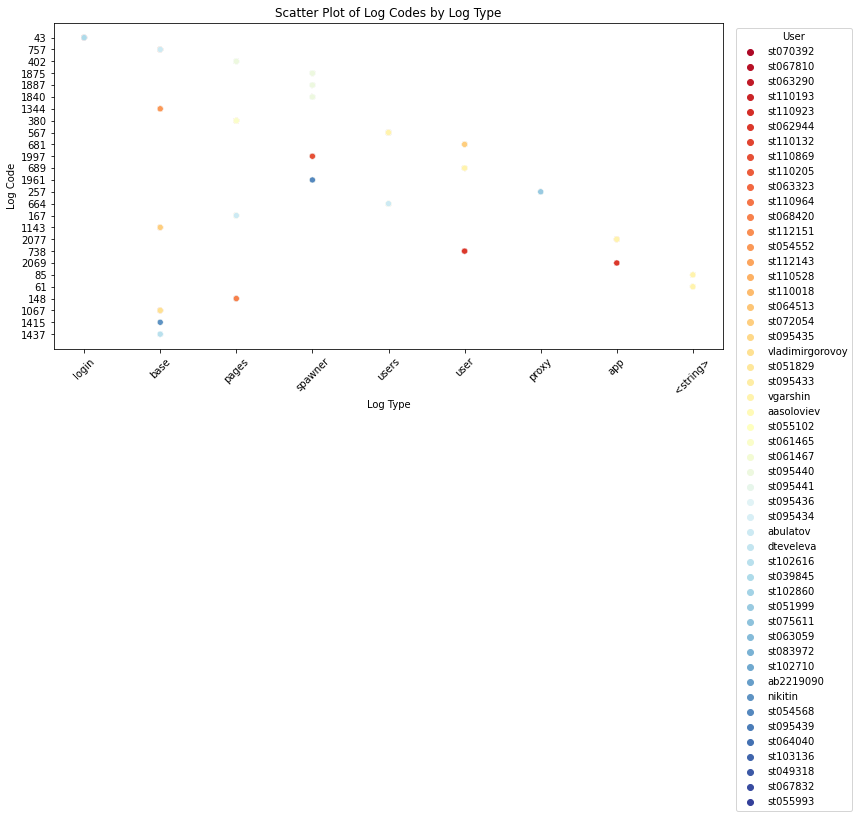

In [41]:
#scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='log_type', y='log_code', hue='user', palette='RdYlBu')
plt.title('Scatter Plot of Log Codes by Log Type')
plt.xlabel('Log Type')
plt.ylabel('Log Code')
plt.xticks(rotation=45)
plt.legend(title='User', loc='upper right', bbox_to_anchor=(1.20, 1))
plt.show()

#### 3.2. Kubernetes logs

Managed Kubernetes is a platform where JupyterHub is installed, so its logs are useful too.

In [42]:
# here is an example for one month
mask_files_ke = '{}/{}/{}/{}/{}/*/*'.format(
    'fluent-bit-logs/kube.var.log.containers.eventrouter*',
    '2023',  # year
    '01',    # month
    '*',    # day
    '*'      # hour
)

In [43]:
sdf = spark.read.json(f's3a://{BUCKET}/{mask_files_ke}')

In [44]:
sdf.count()

6884

In [45]:
sdf.printSchema()

root
 |-- date: string (nullable = true)
 |-- kubernetes: struct (nullable = true)
 |    |-- container_hash: string (nullable = true)
 |    |-- container_image: string (nullable = true)
 |    |-- container_name: string (nullable = true)
 |    |-- docker_id: string (nullable = true)
 |    |-- host: string (nullable = true)
 |    |-- labels: struct (nullable = true)
 |    |    |-- app: string (nullable = true)
 |    |    |-- pod-template-hash: string (nullable = true)
 |    |    |-- tier: string (nullable = true)
 |    |-- namespace_name: string (nullable = true)
 |    |-- pod_id: string (nullable = true)
 |    |-- pod_name: string (nullable = true)
 |-- log: string (nullable = true)
 |-- stream: string (nullable = true)
 |-- time: string (nullable = true)



In [46]:
sdf.limit(5).toPandas()

,date,kubernetes,log,stream,time
0,2023-01-27T10:02:02.017418Z,(gcr.io/heptio-images/eventrouter@sha256:dba60...,I0127 10:02:02.017223 1 glogsink.go:42] ...,stderr,2023-01-27T10:02:02.017418105Z
1,2023-01-27T10:02:02.017497Z,(gcr.io/heptio-images/eventrouter@sha256:dba60...,I0127 10:02:02.017288 1 glogsink.go:42] ...,stderr,2023-01-27T10:02:02.017497268Z
2,2023-01-27T10:02:02.017510Z,(gcr.io/heptio-images/eventrouter@sha256:dba60...,I0127 10:02:02.017382 1 glogsink.go:42] ...,stderr,2023-01-27T10:02:02.017510417Z
3,2023-01-27T10:02:02.017524Z,(gcr.io/heptio-images/eventrouter@sha256:dba60...,I0127 10:02:02.017439 1 glogsink.go:42] ...,stderr,2023-01-27T10:02:02.017524861Z
4,2023-01-27T10:02:02.017534Z,(gcr.io/heptio-images/eventrouter@sha256:dba60...,I0127 10:02:02.017461 1 glogsink.go:42] ...,stderr,2023-01-27T10:02:02.017534925Z


Again, clean the data and create table for analysis:

In [47]:
def parce_event(s):
    try:
        s = s[s.find(']') + 2 :]
        s = json.loads(s)
        verb = s['verb']
        event_uid = s['event']['metadata']['uid']
        event_creation_timestamp = s['event']['metadata']['creationTimestamp']
        event_name = s['event']['metadata']['name']
        event_namespace = s['event']['metadata']['namespace']
        involved_object_kind = s['event']['involvedObject']['kind']
        involved_object_namespace = s['event']['involvedObject']['namespace']
        involved_object_name = s['event']['involvedObject']['name']
        event_reason = s['event']['reason']
        event_message = s['event']['message']
    except:
        verb = ''
        event_uid = ''
        event_creation_timestamp = ''
        event_name = ''
        event_namespace = ''
        involved_object_kind = ''
        involved_object_namespace = ''
        involved_object_name = ''
        event_reason = ''
        event_message = ''
    return verb, event_uid, event_creation_timestamp, event_name, \
        event_namespace, involved_object_kind, involved_object_namespace, \
        involved_object_name, event_reason, event_message

In [48]:
sdf = flat_df(sdf)
sdf = flat_df(sdf)
sdf = sdf.drop(
    'date', 'kubernetes_container_hash',
    'kubernetes_container_image', 'kubernetes_container_name',
    'kubernetes_docker_id', 'kubernetes_namespace_name',
    'kubernetes_pod_id', 'kubernetes_labels_app',
    'kubernetes_labels_pod-template-hash', 'kubernetes_labels_tier'
)
udf_parce_events = udf(parce_event, ArrayType(StringType()))
sdf = sdf.withColumn('log_msg', udf_parce_events('log'))
sdf = sdf.select(
    F.col('time').alias('time_stamp'),
    'stream',
    'kubernetes_host',
    'kubernetes_pod_name',
    F.col('log_msg')[0].alias('verb'),
    F.col('log_msg')[1].alias('event_uid'),
    F.col('log_msg')[2].alias('event_creation_timestamp'),
    F.col('log_msg')[3].alias('event_name'),
    F.col('log_msg')[4].alias('event_namespace'),
    F.col('log_msg')[5].alias('involved_object_kind'),
    F.col('log_msg')[6].alias('involved_object_namespace'),
    F.col('log_msg')[7].alias('involved_object_name'),
    F.col('log_msg')[8].alias('event_reason'),
    F.col('log_msg')[9].alias('event_message')
)
sdf = sdf.withColumn(
    'time_stamp',
    F.to_timestamp("time_stamp", "yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS'Z'")
)
sdf = sdf.withColumn(
    'event_creation_timestamp',
    F.to_timestamp("event_creation_timestamp", "yyyy-MM-dd'T'HH:mm:ss'Z'")
)

In [49]:
sdf.limit(5).toPandas()

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,time_stamp,stream,kubernetes_host,kubernetes_pod_name,verb,event_uid,event_creation_timestamp,event_name,event_namespace,involved_object_kind,involved_object_namespace,involved_object_name,event_reason,event_message
0,2023-01-27 10:02:02.017418,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,UPDATED,188cd51e-a5ac-47c9-8847-b111140e5de7,2023-01-27 09:09:08,jupyter-st095435.173e1f51f65dfaec,jhub,Pod,jhub,jupyter-st095435,SuccessfulAttachVolume,"AttachVolume.Attach succeeded for volume ""pvc-..."
1,2023-01-27 10:02:02.017497,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,UPDATED,2aa85ef0-8214-4027-8d2c-47220282426d,2023-01-27 09:08:57,jupyter-st095435.173e1f4f677f3584,jhub,Pod,jhub,jupyter-st095435,FailedScheduling,"0/2 nodes are available: 1 Insufficient cpu, 1..."
2,2023-01-27 10:02:02.017510,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,UPDATED,a1c614bf-5b6c-4bd5-8d46-8db72a367fd4,2023-01-27 09:08:58,coredns-5f8dbbff8f-cmmhh.173e1f4f9aa54342,kube-system,Pod,kube-system,coredns-5f8dbbff8f-cmmhh,Scheduled,Successfully assigned kube-system/coredns-5f8d...
3,2023-01-27 10:02:02.017524,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,UPDATED,078168d0-35af-4c30-a64a-af4b43a77198,2023-01-27 09:18:44,jupyter-st095435.173e1fd83ae331b0,jhub,Pod,jhub,jupyter-st095435,SuccessfulAttachVolume,"AttachVolume.Attach succeeded for volume ""pvc-..."
4,2023-01-27 10:02:02.017534,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,UPDATED,4638a643-e60c-4b35-aad1-407690edc1ae,2023-01-27 09:18:44,jupyter-st095435.173e1fd83b0619c9,jhub,Pod,jhub,jupyter-st095435,SuccessfulAttachVolume,"AttachVolume.Attach succeeded for volume ""pvc-..."
